<a href="https://colab.research.google.com/github/WoojinJeonkr/DeepLearning/blob/main/Next_Frame_Video_Prediction_with_Convolutional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional_LSTM을 이용한 다음 프레임 비디오 예측

## Convolutional_LSTM
- LSTM 계층에 convolutional recurrent cell을 도입하여 시계열 처리와 컴퓨터 비전을 결합

## 01. 라이브러리 임포트

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## 02. 데이터세트 다운로드
- 사용 데이터 세트: Moving Mnist 데이터 세트

In [2]:
# 데이터세트 다운로드
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

819216384/819200096 [==============================] - 19s 0us/step


In [3]:
# swap dataset
dataset = np.swapaxes(dataset, 0, 1)

In [4]:
dataset = dataset[:1000, ...]
dataset = np.expand_dims(dataset, axis=-1)

In [5]:
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

In [6]:
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

In [7]:
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

In [8]:
# 데이터세트 형태 보기
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


## 03. 데이터 시각화

Displaying frames for example 710.


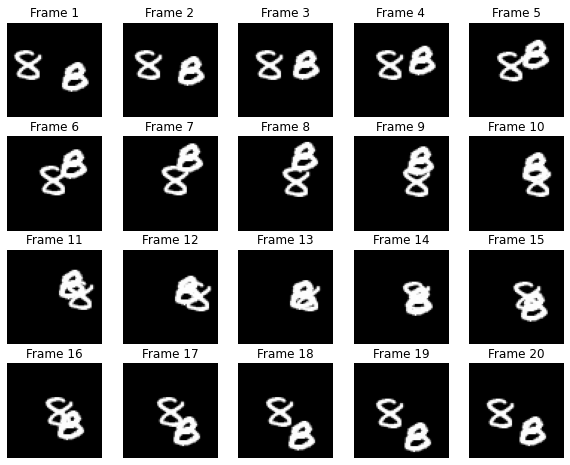

In [9]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

print(f"Displaying frames for example {data_choice}.")
plt.show()

## 04. 모델 구축

In [10]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

In [11]:
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

In [12]:
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

## 05. 모델 훈련

In [13]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

In [14]:
# 하이퍼파라미터 설정
epochs = 20
batch_size = 5

In [ ]:
# 모델 훈련
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/20
180/180 [==============================] - 9143s 51s/step - loss: 0.1124 - val_loss: 0.2583 - lr: 0.0010
Epoch 2/20
180/180 [==============================] - 9068s 50s/step - loss: 0.0301 - val_loss: 0.2164 - lr: 0.0010
Epoch 3/20
 37/180 [=====>........................] - ETA: 1:57:16 - loss: 0.0281